In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import random
import h5py
import copy
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
import tensorflow as tf

In [2]:
def generator_f(data,size,snr,X,Y_):
    signal=np.zeros([size,8192])
    label=np.zeros([size,2])
    data=random.sample(data,size/2)
    data=np.array(data)
    for i in range(size):
        if i%2==0:
            r=random.randint(0,1638)
            label[i]=[0,1]
            signal[i,0:8191-r:1]=data[i/2,r:8191:1]*snr
            signal[i]+=np.random.normal(0,1,8192)
            signal[i]=signal[i]/np.std(signal[i])
        else:
            label[i]=[1,0]
            signal[i]=np.random.normal(0,1,8192)
    feed_dict={
        X:signal,
        Y_:label,
    }
    return feed_dict    

def generator_r(data,size,snr,X,Y_):
    signal=np.zeros([size,8192])
    label=np.zeros([size,2])
    data=random.sample(data,size/2)
    data=np.array(data)
    for i in range(size):
        if i%2==0:
            r=random.randint(0,1638)
            label[i]=[0,1]
            signal[i,0:8191-r:1]=data[i/2,r:8191:1]*random.uniform(snr,2)
            signal[i]+=np.random.normal(0,1,8192)
            signal[i]=signal[i]/np.std(signal[i])
        else:
            label[i]=[1,0]
            signal[i]=np.random.normal(0,1,8192)
    feed_dict={
        X:signal,
        Y_:label,
    }
    return feed_dict    

In [3]:
#get data
f=h5py.File('dataset.h5','r')
testsig=list(f['test'])
trainsig=list(f['train'])


In [4]:
sess=tf.Session()

#initial weight
def weight_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.contrib.layers.xavier_initializer())
#intial bias
def bias_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.constant_initializer(0.1))
#placeholder
with tf.name_scope('Input'):
    X=tf.placeholder(tf.float32,[None,8192])
with tf.name_scope('Label'):
    Y_=tf.placeholder(tf.float32,[None,2]

#reshape layer
with tf.name_scope('Reshape_layer'):
    XX=tf.reshape(X,[-1,8192,1,1])
#convolution layer 1
w_conv1=weight_variable('w_conv1',[16,1,1,32])
b_conv1=bias_variable('b_conv1',[32])
with tf.name_scope('Convolution_layer1'):
    conv1=tf.nn.conv2d(XX,w_conv1,strides=[1,1,1,1],padding='VALID')
print(conv1.shape)

#activation layer 1
with tf.name_scope('Relu_layer1'):
    h_conv1=tf.nn.relu(conv1+b_conv1)

#pooling layer 1
with tf.name_scope('Pooling_layer1'):
    h_pool1=tf.nn.max_pool(h_conv1,[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool1.shape)

#convolution layer 2
w_conv2=weight_variable('w_conv2',[8,1,32,64])
b_conv2=bias_variable('b_conv2',[64])
with tf.name_scope('Convolution_layer2'):
    conv2=tf.nn.atrous_conv2d(h_pool1,w_conv2,rate=4,padding='VALID')
print(conv2.shape)

#activation layer 2
with tf.name_scope('Relu_layer2'):
    h_conv2=tf.nn.relu(conv2+b_conv2)

#pooling layer 2
with tf.name_scope('Pooling_layer2'):
    h_pool2=tf.nn.max_pool(h_conv2,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool2)

#convolution layer 3
w_conv3=weight_variable('w_conv3',[8,1,64,128])
b_conv3=bias_variable('b_conv3',[128])
with tf.name_scope('Convolution_layer3'):
    conv3=tf.nn.atrous_conv2d(h_pool2,w_conv3,rate=4,padding='VALID')
print(conv3)

#activation layer 3
with tf.name_scope('Relu_layer3'):
    h_conv3=tf.nn.relu(conv3+b_conv3)

#pooling layer 3
with tf.name_scope('Pooling_layer3'):
    h_pool3=tf.nn.max_pool(h_conv3,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool3.shape)

#flatten layer
with tf.name_scope('Flatten_layer'):
    h_flatten=tf.reshape(h_pool3,[-1,7680*2])
print(h_flatten.shape)

#linear layer 1
w_linear1=weight_variable('w_linear1',[7680*2,64])
b_linear1=bias_variable('b_linear1',[64])

#activation layer 4
with tf.name_scope('Relu_layer4'):
    h_linear1=tf.nn.relu(tf.matmul(h_flatten,w_linear1)+b_linear1)

#linear layer 2
w_linear2=weight_variable('w_linear2',[64,2])
b_linear2=bias_variable('b_linear2',[2])

#activation layer 5
Ylogits=tf.matmul(h_linear1,w_linear2)+b_linear2
with tf.name_scope('Output'):
    Y=tf.nn.softmax(Ylogits)

#loss function
cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits,labels=Y_)
cross_entropy=tf.reduce_mean(cross_entropy)

#accuracy
is_correct=tf.equal(tf.argmax(Y,1),tf.argmax(Y_,1))
accuracy=tf.reduce_mean(tf.cast(is_correct,tf.float32))*100

#optimization
optimizer=tf.train.AdamOptimizer(0.001)
global_step = tf.Variable(0, name='global_step', trainable=False)
train_step=optimizer.minimize(cross_entropy,global_step=global_step)

#save the model
saver=tf.train.Saver()

#visualization
tf.summary.scalar('accuracy',accuracy)
tf.summary.scalar('cross_entropy',tf.log(cross_entropy))
merged=tf.summary.merge_all()
train_writer=tf.summary.FileWriter('/home/txie/project/classifier3/train/',sess.graph)
test_writer=tf.summary.FileWriter('/home/txie/project/classifier3/test/')

#run
sess.run(tf.global_variables_initializer())

(?, 8177, 1, 32)
(?, 2045, 1, 32)
(?, ?, ?, 64)
Tensor("Pooling_layer2/MaxPool:0", shape=(?, ?, ?, 64), dtype=float32)
Tensor("Convolution_layer3/atrous_conv2d/BatchToSpaceND:0", shape=(?, ?, ?, 128), dtype=float32)
(?, ?, ?, 128)
(?, 15360)


In [5]:
#restore the model
ckpt = tf.train.get_checkpoint_state('/home/txie/project/classifier3')  
saver.restore(sess,ckpt.model_checkpoint_path)
print('Model Restored')

Model Restored


In [6]:
#get test data
snr=0.25
test=generator_f(testsig,1480,snr,X,Y_)

In [7]:
#training loop
epoch=5000
for i in range(epoch):
    if (i+1)%100==0:
        summary,a,c=sess.run([merged,accuracy,cross_entropy],feed_dict=test)
        print('test:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
        test_writer.add_summary(summary,tf.train.global_step(sess,global_step))
    feed_dict=generator_f(trainsig,50,snr,X,Y_)
    a,c=sess.run([accuracy,cross_entropy],feed_dict=feed_dict)
    print('epoch:'+str(i)+' accuracy:'+str(a)+' cross_entropy:'+str(c))
    summary,_=sess.run([merged,train_step],feed_dict=feed_dict)
    train_writer.add_summary(summary,tf.train.global_step(sess,global_step))


epoch:0 accuracy:82.0 cross_entropy:0.355341
epoch:1 accuracy:78.0 cross_entropy:0.403011
epoch:2 accuracy:74.0 cross_entropy:0.541253
epoch:3 accuracy:86.0 cross_entropy:0.299746
epoch:4 accuracy:80.0 cross_entropy:0.435674
epoch:5 accuracy:84.0 cross_entropy:0.300755
epoch:6 accuracy:94.0 cross_entropy:0.239922
epoch:7 accuracy:80.0 cross_entropy:0.500504
epoch:8 accuracy:86.0 cross_entropy:0.401757
epoch:9 accuracy:88.0 cross_entropy:0.327082
epoch:10 accuracy:68.0 cross_entropy:0.565378
epoch:11 accuracy:86.0 cross_entropy:0.382169
epoch:12 accuracy:82.0 cross_entropy:0.352412
epoch:13 accuracy:88.0 cross_entropy:0.296901
epoch:14 accuracy:90.0 cross_entropy:0.279428
epoch:15 accuracy:82.0 cross_entropy:0.391276
epoch:16 accuracy:82.0 cross_entropy:0.378507
epoch:17 accuracy:78.0 cross_entropy:0.502451
epoch:18 accuracy:84.0 cross_entropy:0.330775
epoch:19 accuracy:94.0 cross_entropy:0.210863
epoch:20 accuracy:88.0 cross_entropy:0.261537
epoch:21 accuracy:82.0 cross_entropy:0.41664

epoch:177 accuracy:74.0 cross_entropy:0.508767
epoch:178 accuracy:88.0 cross_entropy:0.303172
epoch:179 accuracy:92.0 cross_entropy:0.243964
epoch:180 accuracy:82.0 cross_entropy:0.388596
epoch:181 accuracy:90.0 cross_entropy:0.350367
epoch:182 accuracy:86.0 cross_entropy:0.424663
epoch:183 accuracy:88.0 cross_entropy:0.333755
epoch:184 accuracy:84.0 cross_entropy:0.400129
epoch:185 accuracy:84.0 cross_entropy:0.378256
epoch:186 accuracy:74.0 cross_entropy:0.578482
epoch:187 accuracy:86.0 cross_entropy:0.297651
epoch:188 accuracy:90.0 cross_entropy:0.323518
epoch:189 accuracy:86.0 cross_entropy:0.338607
epoch:190 accuracy:80.0 cross_entropy:0.378992
epoch:191 accuracy:92.0 cross_entropy:0.218036
epoch:192 accuracy:84.0 cross_entropy:0.385932
epoch:193 accuracy:80.0 cross_entropy:0.40593
epoch:194 accuracy:80.0 cross_entropy:0.329476
epoch:195 accuracy:90.0 cross_entropy:0.31856
epoch:196 accuracy:84.0 cross_entropy:0.36557
epoch:197 accuracy:74.0 cross_entropy:0.456092
epoch:198 accura

epoch:351 accuracy:88.0 cross_entropy:0.300989
epoch:352 accuracy:86.0 cross_entropy:0.356938
epoch:353 accuracy:76.0 cross_entropy:0.556114
epoch:354 accuracy:80.0 cross_entropy:0.444837
epoch:355 accuracy:82.0 cross_entropy:0.417729
epoch:356 accuracy:88.0 cross_entropy:0.327104
epoch:357 accuracy:84.0 cross_entropy:0.385741
epoch:358 accuracy:80.0 cross_entropy:0.35571
epoch:359 accuracy:78.0 cross_entropy:0.440778
epoch:360 accuracy:80.0 cross_entropy:0.459631
epoch:361 accuracy:80.0 cross_entropy:0.401072
epoch:362 accuracy:88.0 cross_entropy:0.299276
epoch:363 accuracy:78.0 cross_entropy:0.443446
epoch:364 accuracy:88.0 cross_entropy:0.364796
epoch:365 accuracy:84.0 cross_entropy:0.350449
epoch:366 accuracy:86.0 cross_entropy:0.346823
epoch:367 accuracy:80.0 cross_entropy:0.38815
epoch:368 accuracy:80.0 cross_entropy:0.429292
epoch:369 accuracy:84.0 cross_entropy:0.361877
epoch:370 accuracy:82.0 cross_entropy:0.420078
epoch:371 accuracy:86.0 cross_entropy:0.308447
epoch:372 accur

epoch:525 accuracy:86.0 cross_entropy:0.366131
epoch:526 accuracy:86.0 cross_entropy:0.322611
epoch:527 accuracy:88.0 cross_entropy:0.392078
epoch:528 accuracy:82.0 cross_entropy:0.400427
epoch:529 accuracy:90.0 cross_entropy:0.26158
epoch:530 accuracy:76.0 cross_entropy:0.444916
epoch:531 accuracy:80.0 cross_entropy:0.3633
epoch:532 accuracy:90.0 cross_entropy:0.282714
epoch:533 accuracy:80.0 cross_entropy:0.357306
epoch:534 accuracy:86.0 cross_entropy:0.332237
epoch:535 accuracy:86.0 cross_entropy:0.372068
epoch:536 accuracy:78.0 cross_entropy:0.39593
epoch:537 accuracy:88.0 cross_entropy:0.378254
epoch:538 accuracy:76.0 cross_entropy:0.431999
epoch:539 accuracy:74.0 cross_entropy:0.446558
epoch:540 accuracy:80.0 cross_entropy:0.410346
epoch:541 accuracy:82.0 cross_entropy:0.464232
epoch:542 accuracy:84.0 cross_entropy:0.400871
epoch:543 accuracy:82.0 cross_entropy:0.438662
epoch:544 accuracy:76.0 cross_entropy:0.489435
epoch:545 accuracy:84.0 cross_entropy:0.418567
epoch:546 accurac

test: accuracy:84.5946 cross_entropy:0.360684
epoch:699 accuracy:94.0 cross_entropy:0.260388
epoch:700 accuracy:88.0 cross_entropy:0.383482
epoch:701 accuracy:74.0 cross_entropy:0.49972
epoch:702 accuracy:90.0 cross_entropy:0.285211
epoch:703 accuracy:86.0 cross_entropy:0.321331
epoch:704 accuracy:84.0 cross_entropy:0.372222
epoch:705 accuracy:84.0 cross_entropy:0.409483
epoch:706 accuracy:82.0 cross_entropy:0.431225
epoch:707 accuracy:88.0 cross_entropy:0.338732
epoch:708 accuracy:82.0 cross_entropy:0.362263
epoch:709 accuracy:84.0 cross_entropy:0.413456
epoch:710 accuracy:76.0 cross_entropy:0.37355
epoch:711 accuracy:90.0 cross_entropy:0.314535
epoch:712 accuracy:78.0 cross_entropy:0.441773
epoch:713 accuracy:88.0 cross_entropy:0.310897
epoch:714 accuracy:86.0 cross_entropy:0.289946
epoch:715 accuracy:92.0 cross_entropy:0.264633
epoch:716 accuracy:80.0 cross_entropy:0.37854
epoch:717 accuracy:84.0 cross_entropy:0.401168
epoch:718 accuracy:84.0 cross_entropy:0.51593
epoch:719 accuracy

epoch:873 accuracy:90.0 cross_entropy:0.287918
epoch:874 accuracy:84.0 cross_entropy:0.408559
epoch:875 accuracy:74.0 cross_entropy:0.544168
epoch:876 accuracy:92.0 cross_entropy:0.235322
epoch:877 accuracy:88.0 cross_entropy:0.317322
epoch:878 accuracy:88.0 cross_entropy:0.303299
epoch:879 accuracy:92.0 cross_entropy:0.222665
epoch:880 accuracy:78.0 cross_entropy:0.480925
epoch:881 accuracy:84.0 cross_entropy:0.292635
epoch:882 accuracy:92.0 cross_entropy:0.219079
epoch:883 accuracy:86.0 cross_entropy:0.300758
epoch:884 accuracy:90.0 cross_entropy:0.269464
epoch:885 accuracy:90.0 cross_entropy:0.307994
epoch:886 accuracy:84.0 cross_entropy:0.321939
epoch:887 accuracy:88.0 cross_entropy:0.34745
epoch:888 accuracy:92.0 cross_entropy:0.3058
epoch:889 accuracy:74.0 cross_entropy:0.594527
epoch:890 accuracy:84.0 cross_entropy:0.33335
epoch:891 accuracy:90.0 cross_entropy:0.298278
epoch:892 accuracy:90.0 cross_entropy:0.295761
epoch:893 accuracy:80.0 cross_entropy:0.481198
epoch:894 accurac

epoch:1046 accuracy:86.0 cross_entropy:0.308348
epoch:1047 accuracy:90.0 cross_entropy:0.352477
epoch:1048 accuracy:86.0 cross_entropy:0.377202
epoch:1049 accuracy:72.0 cross_entropy:0.592924
epoch:1050 accuracy:84.0 cross_entropy:0.284639
epoch:1051 accuracy:84.0 cross_entropy:0.355633
epoch:1052 accuracy:86.0 cross_entropy:0.351454
epoch:1053 accuracy:86.0 cross_entropy:0.354575
epoch:1054 accuracy:84.0 cross_entropy:0.354142
epoch:1055 accuracy:82.0 cross_entropy:0.363889
epoch:1056 accuracy:90.0 cross_entropy:0.334555
epoch:1057 accuracy:84.0 cross_entropy:0.357369
epoch:1058 accuracy:82.0 cross_entropy:0.398887
epoch:1059 accuracy:80.0 cross_entropy:0.377881
epoch:1060 accuracy:80.0 cross_entropy:0.400027
epoch:1061 accuracy:88.0 cross_entropy:0.306434
epoch:1062 accuracy:70.0 cross_entropy:0.58673
epoch:1063 accuracy:92.0 cross_entropy:0.349099
epoch:1064 accuracy:86.0 cross_entropy:0.360735
epoch:1065 accuracy:88.0 cross_entropy:0.309808
epoch:1066 accuracy:82.0 cross_entropy:0.

epoch:1216 accuracy:84.0 cross_entropy:0.301438
epoch:1217 accuracy:80.0 cross_entropy:0.462246
epoch:1218 accuracy:86.0 cross_entropy:0.360661
epoch:1219 accuracy:84.0 cross_entropy:0.362397
epoch:1220 accuracy:84.0 cross_entropy:0.364363
epoch:1221 accuracy:86.0 cross_entropy:0.288454
epoch:1222 accuracy:88.0 cross_entropy:0.296487
epoch:1223 accuracy:76.0 cross_entropy:0.470562
epoch:1224 accuracy:76.0 cross_entropy:0.514508
epoch:1225 accuracy:86.0 cross_entropy:0.285343
epoch:1226 accuracy:82.0 cross_entropy:0.442375
epoch:1227 accuracy:86.0 cross_entropy:0.356466
epoch:1228 accuracy:78.0 cross_entropy:0.480436
epoch:1229 accuracy:86.0 cross_entropy:0.272996
epoch:1230 accuracy:76.0 cross_entropy:0.528059
epoch:1231 accuracy:94.0 cross_entropy:0.242627
epoch:1232 accuracy:84.0 cross_entropy:0.345292
epoch:1233 accuracy:78.0 cross_entropy:0.44453
epoch:1234 accuracy:90.0 cross_entropy:0.252073
epoch:1235 accuracy:82.0 cross_entropy:0.361461
epoch:1236 accuracy:88.0 cross_entropy:0.

epoch:1387 accuracy:92.0 cross_entropy:0.240092
epoch:1388 accuracy:80.0 cross_entropy:0.402675
epoch:1389 accuracy:84.0 cross_entropy:0.353591
epoch:1390 accuracy:84.0 cross_entropy:0.392755
epoch:1391 accuracy:78.0 cross_entropy:0.444735
epoch:1392 accuracy:82.0 cross_entropy:0.3743
epoch:1393 accuracy:92.0 cross_entropy:0.272429
epoch:1394 accuracy:88.0 cross_entropy:0.275017
epoch:1395 accuracy:84.0 cross_entropy:0.354772
epoch:1396 accuracy:82.0 cross_entropy:0.422043
epoch:1397 accuracy:84.0 cross_entropy:0.379423
epoch:1398 accuracy:84.0 cross_entropy:0.36314
test: accuracy:83.4459 cross_entropy:0.369171
epoch:1399 accuracy:82.0 cross_entropy:0.488316
epoch:1400 accuracy:90.0 cross_entropy:0.271428
epoch:1401 accuracy:82.0 cross_entropy:0.321038
epoch:1402 accuracy:80.0 cross_entropy:0.421903
epoch:1403 accuracy:72.0 cross_entropy:0.434924
epoch:1404 accuracy:90.0 cross_entropy:0.243868
epoch:1405 accuracy:88.0 cross_entropy:0.318747
epoch:1406 accuracy:90.0 cross_entropy:0.3126

epoch:1558 accuracy:88.0 cross_entropy:0.376717
epoch:1559 accuracy:88.0 cross_entropy:0.346224
epoch:1560 accuracy:88.0 cross_entropy:0.321669
epoch:1561 accuracy:82.0 cross_entropy:0.367041
epoch:1562 accuracy:80.0 cross_entropy:0.452488
epoch:1563 accuracy:78.0 cross_entropy:0.455135
epoch:1564 accuracy:90.0 cross_entropy:0.309738
epoch:1565 accuracy:78.0 cross_entropy:0.471505
epoch:1566 accuracy:80.0 cross_entropy:0.389112
epoch:1567 accuracy:84.0 cross_entropy:0.311718
epoch:1568 accuracy:80.0 cross_entropy:0.460496
epoch:1569 accuracy:84.0 cross_entropy:0.319974
epoch:1570 accuracy:86.0 cross_entropy:0.346611
epoch:1571 accuracy:80.0 cross_entropy:0.376446
epoch:1572 accuracy:84.0 cross_entropy:0.37076
epoch:1573 accuracy:88.0 cross_entropy:0.292487
epoch:1574 accuracy:82.0 cross_entropy:0.424239
epoch:1575 accuracy:96.0 cross_entropy:0.157013
epoch:1576 accuracy:82.0 cross_entropy:0.386191
epoch:1577 accuracy:84.0 cross_entropy:0.383431
epoch:1578 accuracy:92.0 cross_entropy:0.

epoch:1728 accuracy:86.0 cross_entropy:0.367053
epoch:1729 accuracy:88.0 cross_entropy:0.325782
epoch:1730 accuracy:80.0 cross_entropy:0.417728
epoch:1731 accuracy:86.0 cross_entropy:0.353838
epoch:1732 accuracy:86.0 cross_entropy:0.363816
epoch:1733 accuracy:86.0 cross_entropy:0.326614
epoch:1734 accuracy:84.0 cross_entropy:0.387543
epoch:1735 accuracy:84.0 cross_entropy:0.33649
epoch:1736 accuracy:88.0 cross_entropy:0.298364
epoch:1737 accuracy:88.0 cross_entropy:0.333157
epoch:1738 accuracy:78.0 cross_entropy:0.398676
epoch:1739 accuracy:82.0 cross_entropy:0.362239
epoch:1740 accuracy:86.0 cross_entropy:0.34655
epoch:1741 accuracy:86.0 cross_entropy:0.320318
epoch:1742 accuracy:86.0 cross_entropy:0.3572
epoch:1743 accuracy:84.0 cross_entropy:0.336883
epoch:1744 accuracy:82.0 cross_entropy:0.380784
epoch:1745 accuracy:88.0 cross_entropy:0.411998
epoch:1746 accuracy:78.0 cross_entropy:0.479525
epoch:1747 accuracy:88.0 cross_entropy:0.295897
epoch:1748 accuracy:82.0 cross_entropy:0.403

test: accuracy:84.2568 cross_entropy:0.366997
epoch:1899 accuracy:88.0 cross_entropy:0.317411
epoch:1900 accuracy:98.0 cross_entropy:0.185976
epoch:1901 accuracy:80.0 cross_entropy:0.365779
epoch:1902 accuracy:92.0 cross_entropy:0.28296
epoch:1903 accuracy:80.0 cross_entropy:0.462704
epoch:1904 accuracy:86.0 cross_entropy:0.358575
epoch:1905 accuracy:84.0 cross_entropy:0.400423
epoch:1906 accuracy:86.0 cross_entropy:0.313087
epoch:1907 accuracy:82.0 cross_entropy:0.379347
epoch:1908 accuracy:88.0 cross_entropy:0.275011
epoch:1909 accuracy:90.0 cross_entropy:0.342238
epoch:1910 accuracy:86.0 cross_entropy:0.281373
epoch:1911 accuracy:86.0 cross_entropy:0.349143
epoch:1912 accuracy:92.0 cross_entropy:0.254437
epoch:1913 accuracy:86.0 cross_entropy:0.379534
epoch:1914 accuracy:82.0 cross_entropy:0.397777
epoch:1915 accuracy:88.0 cross_entropy:0.294595
epoch:1916 accuracy:82.0 cross_entropy:0.432922
epoch:1917 accuracy:84.0 cross_entropy:0.380655
epoch:1918 accuracy:82.0 cross_entropy:0.37

epoch:2069 accuracy:80.0 cross_entropy:0.422019
epoch:2070 accuracy:82.0 cross_entropy:0.461563
epoch:2071 accuracy:90.0 cross_entropy:0.285559
epoch:2072 accuracy:84.0 cross_entropy:0.409921
epoch:2073 accuracy:80.0 cross_entropy:0.373004
epoch:2074 accuracy:88.0 cross_entropy:0.294687
epoch:2075 accuracy:94.0 cross_entropy:0.26094
epoch:2076 accuracy:82.0 cross_entropy:0.336307
epoch:2077 accuracy:88.0 cross_entropy:0.302239
epoch:2078 accuracy:92.0 cross_entropy:0.268649
epoch:2079 accuracy:82.0 cross_entropy:0.410682
epoch:2080 accuracy:82.0 cross_entropy:0.429999
epoch:2081 accuracy:76.0 cross_entropy:0.502041
epoch:2082 accuracy:76.0 cross_entropy:0.387812
epoch:2083 accuracy:80.0 cross_entropy:0.398293
epoch:2084 accuracy:80.0 cross_entropy:0.339913
epoch:2085 accuracy:94.0 cross_entropy:0.20796
epoch:2086 accuracy:86.0 cross_entropy:0.385968
epoch:2087 accuracy:84.0 cross_entropy:0.454034
epoch:2088 accuracy:88.0 cross_entropy:0.276256
epoch:2089 accuracy:84.0 cross_entropy:0.2

epoch:2241 accuracy:84.0 cross_entropy:0.304955
epoch:2242 accuracy:92.0 cross_entropy:0.233404
epoch:2243 accuracy:86.0 cross_entropy:0.381157
epoch:2244 accuracy:90.0 cross_entropy:0.29003
epoch:2245 accuracy:90.0 cross_entropy:0.261444
epoch:2246 accuracy:82.0 cross_entropy:0.322164
epoch:2247 accuracy:86.0 cross_entropy:0.402455
epoch:2248 accuracy:86.0 cross_entropy:0.337631
epoch:2249 accuracy:76.0 cross_entropy:0.423959
epoch:2250 accuracy:88.0 cross_entropy:0.295957
epoch:2251 accuracy:86.0 cross_entropy:0.301164
epoch:2252 accuracy:84.0 cross_entropy:0.385422
epoch:2253 accuracy:82.0 cross_entropy:0.361595
epoch:2254 accuracy:86.0 cross_entropy:0.353958
epoch:2255 accuracy:74.0 cross_entropy:0.554699
epoch:2256 accuracy:84.0 cross_entropy:0.337653
epoch:2257 accuracy:90.0 cross_entropy:0.298037
epoch:2258 accuracy:86.0 cross_entropy:0.326504
epoch:2259 accuracy:90.0 cross_entropy:0.230272
epoch:2260 accuracy:82.0 cross_entropy:0.437036
epoch:2261 accuracy:94.0 cross_entropy:0.

epoch:2412 accuracy:80.0 cross_entropy:0.42091
epoch:2413 accuracy:82.0 cross_entropy:0.34115
epoch:2414 accuracy:82.0 cross_entropy:0.386377
epoch:2415 accuracy:94.0 cross_entropy:0.23526
epoch:2416 accuracy:82.0 cross_entropy:0.421792
epoch:2417 accuracy:82.0 cross_entropy:0.372342
epoch:2418 accuracy:90.0 cross_entropy:0.257765
epoch:2419 accuracy:78.0 cross_entropy:0.41669
epoch:2420 accuracy:82.0 cross_entropy:0.369423
epoch:2421 accuracy:80.0 cross_entropy:0.387809
epoch:2422 accuracy:88.0 cross_entropy:0.247989
epoch:2423 accuracy:84.0 cross_entropy:0.313099
epoch:2424 accuracy:88.0 cross_entropy:0.29148
epoch:2425 accuracy:88.0 cross_entropy:0.387225
epoch:2426 accuracy:86.0 cross_entropy:0.314406
epoch:2427 accuracy:90.0 cross_entropy:0.24691
epoch:2428 accuracy:78.0 cross_entropy:0.453159
epoch:2429 accuracy:80.0 cross_entropy:0.52128
epoch:2430 accuracy:78.0 cross_entropy:0.387052
epoch:2431 accuracy:88.0 cross_entropy:0.301761
epoch:2432 accuracy:84.0 cross_entropy:0.348745

epoch:2583 accuracy:78.0 cross_entropy:0.408267
epoch:2584 accuracy:80.0 cross_entropy:0.380367
epoch:2585 accuracy:74.0 cross_entropy:0.429282
epoch:2586 accuracy:94.0 cross_entropy:0.215568
epoch:2587 accuracy:90.0 cross_entropy:0.316525
epoch:2588 accuracy:80.0 cross_entropy:0.408062
epoch:2589 accuracy:86.0 cross_entropy:0.330046
epoch:2590 accuracy:88.0 cross_entropy:0.300951
epoch:2591 accuracy:86.0 cross_entropy:0.409828
epoch:2592 accuracy:82.0 cross_entropy:0.340825
epoch:2593 accuracy:78.0 cross_entropy:0.434478
epoch:2594 accuracy:86.0 cross_entropy:0.338115
epoch:2595 accuracy:86.0 cross_entropy:0.310486
epoch:2596 accuracy:88.0 cross_entropy:0.317084
epoch:2597 accuracy:88.0 cross_entropy:0.368612
epoch:2598 accuracy:88.0 cross_entropy:0.306561
test: accuracy:84.4595 cross_entropy:0.360259
epoch:2599 accuracy:84.0 cross_entropy:0.391248
epoch:2600 accuracy:86.0 cross_entropy:0.295583
epoch:2601 accuracy:84.0 cross_entropy:0.317133
epoch:2602 accuracy:84.0 cross_entropy:0.3

epoch:2753 accuracy:78.0 cross_entropy:0.425322
epoch:2754 accuracy:86.0 cross_entropy:0.368808
epoch:2755 accuracy:88.0 cross_entropy:0.320417
epoch:2756 accuracy:78.0 cross_entropy:0.413534
epoch:2757 accuracy:86.0 cross_entropy:0.370142
epoch:2758 accuracy:78.0 cross_entropy:0.392336
epoch:2759 accuracy:92.0 cross_entropy:0.266781
epoch:2760 accuracy:86.0 cross_entropy:0.303311
epoch:2761 accuracy:84.0 cross_entropy:0.418432
epoch:2762 accuracy:78.0 cross_entropy:0.509245
epoch:2763 accuracy:88.0 cross_entropy:0.332154
epoch:2764 accuracy:88.0 cross_entropy:0.274125
epoch:2765 accuracy:86.0 cross_entropy:0.355642
epoch:2766 accuracy:74.0 cross_entropy:0.466889
epoch:2767 accuracy:84.0 cross_entropy:0.328442
epoch:2768 accuracy:86.0 cross_entropy:0.315668
epoch:2769 accuracy:88.0 cross_entropy:0.270784
epoch:2770 accuracy:78.0 cross_entropy:0.470843
epoch:2771 accuracy:86.0 cross_entropy:0.402418
epoch:2772 accuracy:80.0 cross_entropy:0.36163
epoch:2773 accuracy:80.0 cross_entropy:0.

epoch:2923 accuracy:80.0 cross_entropy:0.439719
epoch:2924 accuracy:84.0 cross_entropy:0.40402
epoch:2925 accuracy:84.0 cross_entropy:0.400563
epoch:2926 accuracy:78.0 cross_entropy:0.430949
epoch:2927 accuracy:88.0 cross_entropy:0.311446
epoch:2928 accuracy:86.0 cross_entropy:0.347291
epoch:2929 accuracy:82.0 cross_entropy:0.387619
epoch:2930 accuracy:96.0 cross_entropy:0.220044
epoch:2931 accuracy:80.0 cross_entropy:0.405979
epoch:2932 accuracy:82.0 cross_entropy:0.349988
epoch:2933 accuracy:80.0 cross_entropy:0.473742
epoch:2934 accuracy:86.0 cross_entropy:0.500752
epoch:2935 accuracy:80.0 cross_entropy:0.334529
epoch:2936 accuracy:80.0 cross_entropy:0.357296
epoch:2937 accuracy:76.0 cross_entropy:0.396459
epoch:2938 accuracy:88.0 cross_entropy:0.322472
epoch:2939 accuracy:86.0 cross_entropy:0.271968
epoch:2940 accuracy:82.0 cross_entropy:0.420343
epoch:2941 accuracy:88.0 cross_entropy:0.299548
epoch:2942 accuracy:84.0 cross_entropy:0.33454
epoch:2943 accuracy:90.0 cross_entropy:0.2

epoch:3096 accuracy:78.0 cross_entropy:0.41
epoch:3097 accuracy:90.0 cross_entropy:0.279404
epoch:3098 accuracy:72.0 cross_entropy:0.560823
test: accuracy:84.5946 cross_entropy:0.358695
epoch:3099 accuracy:88.0 cross_entropy:0.296467
epoch:3100 accuracy:80.0 cross_entropy:0.344778
epoch:3101 accuracy:78.0 cross_entropy:0.460485
epoch:3102 accuracy:82.0 cross_entropy:0.361829
epoch:3103 accuracy:80.0 cross_entropy:0.506675
epoch:3104 accuracy:88.0 cross_entropy:0.32144
epoch:3105 accuracy:88.0 cross_entropy:0.418054
epoch:3106 accuracy:76.0 cross_entropy:0.408182
epoch:3107 accuracy:92.0 cross_entropy:0.213735
epoch:3108 accuracy:86.0 cross_entropy:0.335953
epoch:3109 accuracy:86.0 cross_entropy:0.363459
epoch:3110 accuracy:76.0 cross_entropy:0.43145
epoch:3111 accuracy:86.0 cross_entropy:0.369689
epoch:3112 accuracy:84.0 cross_entropy:0.338869
epoch:3113 accuracy:86.0 cross_entropy:0.304188
epoch:3114 accuracy:90.0 cross_entropy:0.330839
epoch:3115 accuracy:82.0 cross_entropy:0.360683


epoch:3266 accuracy:76.0 cross_entropy:0.520154
epoch:3267 accuracy:90.0 cross_entropy:0.331525
epoch:3268 accuracy:94.0 cross_entropy:0.284665
epoch:3269 accuracy:82.0 cross_entropy:0.40348
epoch:3270 accuracy:88.0 cross_entropy:0.242578
epoch:3271 accuracy:84.0 cross_entropy:0.380424
epoch:3272 accuracy:84.0 cross_entropy:0.421107
epoch:3273 accuracy:88.0 cross_entropy:0.334722
epoch:3274 accuracy:94.0 cross_entropy:0.220342
epoch:3275 accuracy:78.0 cross_entropy:0.424384
epoch:3276 accuracy:84.0 cross_entropy:0.320438
epoch:3277 accuracy:74.0 cross_entropy:0.524661
epoch:3278 accuracy:82.0 cross_entropy:0.407445
epoch:3279 accuracy:82.0 cross_entropy:0.336704
epoch:3280 accuracy:88.0 cross_entropy:0.419666
epoch:3281 accuracy:80.0 cross_entropy:0.446237
epoch:3282 accuracy:72.0 cross_entropy:0.559829
epoch:3283 accuracy:80.0 cross_entropy:0.395988
epoch:3284 accuracy:82.0 cross_entropy:0.388362
epoch:3285 accuracy:88.0 cross_entropy:0.370646
epoch:3286 accuracy:84.0 cross_entropy:0.

epoch:3436 accuracy:86.0 cross_entropy:0.335469
epoch:3437 accuracy:82.0 cross_entropy:0.323483
epoch:3438 accuracy:84.0 cross_entropy:0.341048
epoch:3439 accuracy:88.0 cross_entropy:0.293204
epoch:3440 accuracy:86.0 cross_entropy:0.335889
epoch:3441 accuracy:84.0 cross_entropy:0.333229
epoch:3442 accuracy:90.0 cross_entropy:0.278818
epoch:3443 accuracy:86.0 cross_entropy:0.364475
epoch:3444 accuracy:86.0 cross_entropy:0.38096
epoch:3445 accuracy:78.0 cross_entropy:0.418876
epoch:3446 accuracy:90.0 cross_entropy:0.246693
epoch:3447 accuracy:84.0 cross_entropy:0.419545
epoch:3448 accuracy:76.0 cross_entropy:0.502749
epoch:3449 accuracy:88.0 cross_entropy:0.265775
epoch:3450 accuracy:84.0 cross_entropy:0.374903
epoch:3451 accuracy:86.0 cross_entropy:0.304536
epoch:3452 accuracy:86.0 cross_entropy:0.353271
epoch:3453 accuracy:82.0 cross_entropy:0.385794
epoch:3454 accuracy:84.0 cross_entropy:0.360272
epoch:3455 accuracy:82.0 cross_entropy:0.398385
epoch:3456 accuracy:88.0 cross_entropy:0.

epoch:3607 accuracy:88.0 cross_entropy:0.313723
epoch:3608 accuracy:92.0 cross_entropy:0.262123
epoch:3609 accuracy:86.0 cross_entropy:0.332896
epoch:3610 accuracy:86.0 cross_entropy:0.362205
epoch:3611 accuracy:82.0 cross_entropy:0.353554
epoch:3612 accuracy:76.0 cross_entropy:0.436205
epoch:3613 accuracy:86.0 cross_entropy:0.383824
epoch:3614 accuracy:84.0 cross_entropy:0.400683
epoch:3615 accuracy:80.0 cross_entropy:0.392151
epoch:3616 accuracy:84.0 cross_entropy:0.416292
epoch:3617 accuracy:82.0 cross_entropy:0.341896
epoch:3618 accuracy:86.0 cross_entropy:0.390858
epoch:3619 accuracy:86.0 cross_entropy:0.423041
epoch:3620 accuracy:72.0 cross_entropy:0.550243
epoch:3621 accuracy:90.0 cross_entropy:0.299177
epoch:3622 accuracy:80.0 cross_entropy:0.475501
epoch:3623 accuracy:82.0 cross_entropy:0.360072
epoch:3624 accuracy:80.0 cross_entropy:0.363705
epoch:3625 accuracy:88.0 cross_entropy:0.280283
epoch:3626 accuracy:94.0 cross_entropy:0.270389
epoch:3627 accuracy:84.0 cross_entropy:0

epoch:3779 accuracy:78.0 cross_entropy:0.424339
epoch:3780 accuracy:74.0 cross_entropy:0.593669
epoch:3781 accuracy:82.0 cross_entropy:0.416769
epoch:3782 accuracy:86.0 cross_entropy:0.356048
epoch:3783 accuracy:84.0 cross_entropy:0.339706
epoch:3784 accuracy:82.0 cross_entropy:0.430789
epoch:3785 accuracy:78.0 cross_entropy:0.498702
epoch:3786 accuracy:84.0 cross_entropy:0.420095
epoch:3787 accuracy:88.0 cross_entropy:0.310244
epoch:3788 accuracy:78.0 cross_entropy:0.426957
epoch:3789 accuracy:86.0 cross_entropy:0.375573
epoch:3790 accuracy:88.0 cross_entropy:0.264107
epoch:3791 accuracy:92.0 cross_entropy:0.297262
epoch:3792 accuracy:84.0 cross_entropy:0.338256
epoch:3793 accuracy:78.0 cross_entropy:0.427991
epoch:3794 accuracy:84.0 cross_entropy:0.409568
epoch:3795 accuracy:76.0 cross_entropy:0.439685
epoch:3796 accuracy:82.0 cross_entropy:0.473361
epoch:3797 accuracy:88.0 cross_entropy:0.377926
epoch:3798 accuracy:84.0 cross_entropy:0.323781
test: accuracy:83.9865 cross_entropy:0.3

epoch:3949 accuracy:86.0 cross_entropy:0.318979
epoch:3950 accuracy:88.0 cross_entropy:0.309706
epoch:3951 accuracy:86.0 cross_entropy:0.329225
epoch:3952 accuracy:78.0 cross_entropy:0.487073
epoch:3953 accuracy:84.0 cross_entropy:0.388241
epoch:3954 accuracy:82.0 cross_entropy:0.407055
epoch:3955 accuracy:84.0 cross_entropy:0.379469
epoch:3956 accuracy:94.0 cross_entropy:0.236428
epoch:3957 accuracy:84.0 cross_entropy:0.36171
epoch:3958 accuracy:84.0 cross_entropy:0.306804
epoch:3959 accuracy:90.0 cross_entropy:0.262101
epoch:3960 accuracy:88.0 cross_entropy:0.308132
epoch:3961 accuracy:86.0 cross_entropy:0.264409
epoch:3962 accuracy:84.0 cross_entropy:0.327082
epoch:3963 accuracy:78.0 cross_entropy:0.461084
epoch:3964 accuracy:76.0 cross_entropy:0.503044
epoch:3965 accuracy:74.0 cross_entropy:0.525717
epoch:3966 accuracy:84.0 cross_entropy:0.371274
epoch:3967 accuracy:84.0 cross_entropy:0.423925
epoch:3968 accuracy:78.0 cross_entropy:0.512917
epoch:3969 accuracy:82.0 cross_entropy:0.

epoch:4120 accuracy:86.0 cross_entropy:0.324713
epoch:4121 accuracy:86.0 cross_entropy:0.341464
epoch:4122 accuracy:84.0 cross_entropy:0.396842
epoch:4123 accuracy:84.0 cross_entropy:0.392219
epoch:4124 accuracy:86.0 cross_entropy:0.349214
epoch:4125 accuracy:92.0 cross_entropy:0.275597
epoch:4126 accuracy:84.0 cross_entropy:0.361579
epoch:4127 accuracy:80.0 cross_entropy:0.367688
epoch:4128 accuracy:78.0 cross_entropy:0.511634
epoch:4129 accuracy:80.0 cross_entropy:0.440186
epoch:4130 accuracy:88.0 cross_entropy:0.308953
epoch:4131 accuracy:82.0 cross_entropy:0.325181
epoch:4132 accuracy:92.0 cross_entropy:0.289966
epoch:4133 accuracy:94.0 cross_entropy:0.237828
epoch:4134 accuracy:84.0 cross_entropy:0.370904
epoch:4135 accuracy:90.0 cross_entropy:0.241731
epoch:4136 accuracy:84.0 cross_entropy:0.2936
epoch:4137 accuracy:84.0 cross_entropy:0.457549
epoch:4138 accuracy:78.0 cross_entropy:0.454318
epoch:4139 accuracy:80.0 cross_entropy:0.525296
epoch:4140 accuracy:86.0 cross_entropy:0.2

epoch:4291 accuracy:86.0 cross_entropy:0.311597
epoch:4292 accuracy:78.0 cross_entropy:0.433332
epoch:4293 accuracy:82.0 cross_entropy:0.333506
epoch:4294 accuracy:72.0 cross_entropy:0.522279
epoch:4295 accuracy:88.0 cross_entropy:0.331904
epoch:4296 accuracy:78.0 cross_entropy:0.420017
epoch:4297 accuracy:80.0 cross_entropy:0.38309
epoch:4298 accuracy:84.0 cross_entropy:0.335806
test: accuracy:81.6216 cross_entropy:0.397204
epoch:4299 accuracy:92.0 cross_entropy:0.258077
epoch:4300 accuracy:82.0 cross_entropy:0.356955
epoch:4301 accuracy:86.0 cross_entropy:0.475625
epoch:4302 accuracy:84.0 cross_entropy:0.327287
epoch:4303 accuracy:76.0 cross_entropy:0.414958
epoch:4304 accuracy:84.0 cross_entropy:0.455788
epoch:4305 accuracy:76.0 cross_entropy:0.433852
epoch:4306 accuracy:86.0 cross_entropy:0.401242
epoch:4307 accuracy:90.0 cross_entropy:0.344452
epoch:4308 accuracy:90.0 cross_entropy:0.299151
epoch:4309 accuracy:72.0 cross_entropy:0.566921
epoch:4310 accuracy:88.0 cross_entropy:0.40

epoch:4461 accuracy:82.0 cross_entropy:0.556971
epoch:4462 accuracy:80.0 cross_entropy:0.363117
epoch:4463 accuracy:80.0 cross_entropy:0.382276
epoch:4464 accuracy:88.0 cross_entropy:0.308049
epoch:4465 accuracy:82.0 cross_entropy:0.439386
epoch:4466 accuracy:88.0 cross_entropy:0.250403
epoch:4467 accuracy:74.0 cross_entropy:0.507227
epoch:4468 accuracy:86.0 cross_entropy:0.358446
epoch:4469 accuracy:80.0 cross_entropy:0.413937
epoch:4470 accuracy:88.0 cross_entropy:0.276359
epoch:4471 accuracy:86.0 cross_entropy:0.305269
epoch:4472 accuracy:82.0 cross_entropy:0.375118
epoch:4473 accuracy:82.0 cross_entropy:0.394227
epoch:4474 accuracy:86.0 cross_entropy:0.352368
epoch:4475 accuracy:82.0 cross_entropy:0.356266
epoch:4476 accuracy:88.0 cross_entropy:0.278074
epoch:4477 accuracy:90.0 cross_entropy:0.283578
epoch:4478 accuracy:88.0 cross_entropy:0.261725
epoch:4479 accuracy:80.0 cross_entropy:0.508899
epoch:4480 accuracy:78.0 cross_entropy:0.423821
epoch:4481 accuracy:88.0 cross_entropy:0

epoch:4632 accuracy:84.0 cross_entropy:0.361676
epoch:4633 accuracy:84.0 cross_entropy:0.300104
epoch:4634 accuracy:72.0 cross_entropy:0.562213
epoch:4635 accuracy:86.0 cross_entropy:0.309878
epoch:4636 accuracy:84.0 cross_entropy:0.278605
epoch:4637 accuracy:78.0 cross_entropy:0.461044
epoch:4638 accuracy:88.0 cross_entropy:0.314262
epoch:4639 accuracy:86.0 cross_entropy:0.299913
epoch:4640 accuracy:84.0 cross_entropy:0.338368
epoch:4641 accuracy:86.0 cross_entropy:0.3125
epoch:4642 accuracy:78.0 cross_entropy:0.413692
epoch:4643 accuracy:82.0 cross_entropy:0.530938
epoch:4644 accuracy:74.0 cross_entropy:0.537224
epoch:4645 accuracy:86.0 cross_entropy:0.409412
epoch:4646 accuracy:84.0 cross_entropy:0.346875
epoch:4647 accuracy:92.0 cross_entropy:0.277714
epoch:4648 accuracy:80.0 cross_entropy:0.299645
epoch:4649 accuracy:82.0 cross_entropy:0.397774
epoch:4650 accuracy:86.0 cross_entropy:0.291583
epoch:4651 accuracy:76.0 cross_entropy:0.507895
epoch:4652 accuracy:84.0 cross_entropy:0.4

epoch:4803 accuracy:90.0 cross_entropy:0.294315
epoch:4804 accuracy:74.0 cross_entropy:0.554192
epoch:4805 accuracy:86.0 cross_entropy:0.304896
epoch:4806 accuracy:90.0 cross_entropy:0.307555
epoch:4807 accuracy:80.0 cross_entropy:0.403516
epoch:4808 accuracy:78.0 cross_entropy:0.368567
epoch:4809 accuracy:82.0 cross_entropy:0.513996
epoch:4810 accuracy:82.0 cross_entropy:0.390044
epoch:4811 accuracy:78.0 cross_entropy:0.426346
epoch:4812 accuracy:82.0 cross_entropy:0.387857
epoch:4813 accuracy:86.0 cross_entropy:0.332954
epoch:4814 accuracy:88.0 cross_entropy:0.271856
epoch:4815 accuracy:88.0 cross_entropy:0.291037
epoch:4816 accuracy:86.0 cross_entropy:0.323072
epoch:4817 accuracy:82.0 cross_entropy:0.441885
epoch:4818 accuracy:84.0 cross_entropy:0.356928
epoch:4819 accuracy:90.0 cross_entropy:0.253622
epoch:4820 accuracy:90.0 cross_entropy:0.221624
epoch:4821 accuracy:88.0 cross_entropy:0.291064
epoch:4822 accuracy:80.0 cross_entropy:0.437589
epoch:4823 accuracy:92.0 cross_entropy:0

epoch:4973 accuracy:84.0 cross_entropy:0.350789
epoch:4974 accuracy:96.0 cross_entropy:0.245312
epoch:4975 accuracy:86.0 cross_entropy:0.34605
epoch:4976 accuracy:88.0 cross_entropy:0.341125
epoch:4977 accuracy:88.0 cross_entropy:0.289111
epoch:4978 accuracy:82.0 cross_entropy:0.471179
epoch:4979 accuracy:80.0 cross_entropy:0.388334
epoch:4980 accuracy:88.0 cross_entropy:0.323185
epoch:4981 accuracy:84.0 cross_entropy:0.450212
epoch:4982 accuracy:86.0 cross_entropy:0.325856
epoch:4983 accuracy:80.0 cross_entropy:0.3602
epoch:4984 accuracy:84.0 cross_entropy:0.322499
epoch:4985 accuracy:86.0 cross_entropy:0.326156
epoch:4986 accuracy:84.0 cross_entropy:0.420861
epoch:4987 accuracy:82.0 cross_entropy:0.40106
epoch:4988 accuracy:84.0 cross_entropy:0.388389
epoch:4989 accuracy:88.0 cross_entropy:0.33078
epoch:4990 accuracy:88.0 cross_entropy:0.263493
epoch:4991 accuracy:82.0 cross_entropy:0.315265
epoch:4992 accuracy:86.0 cross_entropy:0.357182
epoch:4993 accuracy:68.0 cross_entropy:0.6091

In [8]:
#save the model
saver.save(sess, '/home/txie/project/classifier3/classifier.ckpt', global_step=epoch)
print('Model Saved')

Model Saved


0.2
test: accuracy:73.9189 cross_entropy:0.530316
0.3
test: accuracy:88.2433 cross_entropy:0.282761
0.4
test: accuracy:92.7703 cross_entropy:0.221615
0.5
test: accuracy:92.7027 cross_entropy:0.210108
0.6
test: accuracy:92.4324 cross_entropy:0.211999
0.7
test: accuracy:93.3108 cross_entropy:0.207518
0.8
test: accuracy:92.973 cross_entropy:0.204331
0.9
test: accuracy:93.6487 cross_entropy:0.183565
1.0
test: accuracy:93.9189 cross_entropy:0.194395
1.1
test: accuracy:94.1892 cross_entropy:0.192426
1.2
test: accuracy:93.7162 cross_entropy:0.187132
1.3
test: accuracy:93.9865 cross_entropy:0.196446
1.4
test: accuracy:92.5676 cross_entropy:0.194186
1.5
test: accuracy:94.1216 cross_entropy:0.178329
1.6
test: accuracy:93.6487 cross_entropy:0.200566
1.7
test: accuracy:93.9865 cross_entropy:0.188659
1.8
test: accuracy:93.7838 cross_entropy:0.183325
1.9
test: accuracy:94.8649 cross_entropy:0.185117
2.0
test: accuracy:93.3784 cross_entropy:0.20069
2.1
test: accuracy:94.5946 cross_entropy:0.184157
2.

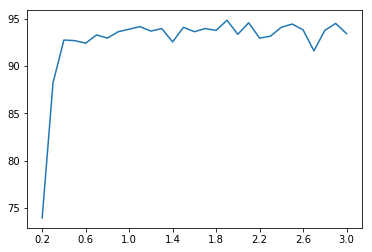

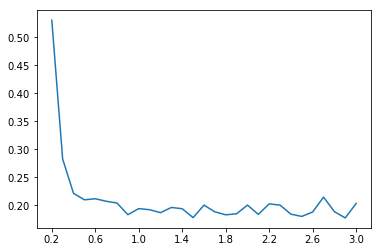

In [9]:
snr=np.linspace(0.2,3,29)
ac=[]
error=[]
for i in range(29):
    print(snr[i])
    test=generator_f(testsig,1480,snr[i],X,Y_)
    a,c=sess.run([accuracy,cross_entropy],feed_dict=test)
    print('test:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
    ac.append(a)
    error.append(c)
test=generator_f(testsig,1480,0.25,X,Y_)
a,c=sess.run([accuracy,cross_entropy],feed_dict=test)
print('snr=0.25:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
plt.figure()
plt.xticks(np.linspace(0.2,3,8))
plt.plot(snr,ac)
plt.figure()
plt.xticks(np.linspace(0.2,3,8))
plt.plot(snr,error)
plt.show()

    